In [2]:
import pandas as pd
import nltk
import numpy as np
from textblob import TextBlob

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, GlobalAveragePooling1D, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import TensorBoard
import datetime


Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
def calculate_metrics(df):
    """
    Calculates the average sentence length, average grammatical complexity, and average sentiment
    score for each row of text in the input DataFrame.
    
    Parameters:
        df (Pandas DataFrame): A DataFrame with a single column of text
    
    Returns:
        Pandas DataFrame: A new DataFrame with the columns 'average_sentence_length', 'average_grammatical_complexity',
        and 'average_sentiment'
    """
    # Define a function to calculate the POS tag count for a given sentence
    def pos_tag_count(sentence):
        pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
        tag_count = len(pos_tags)
        return tag_count
    
    # Define a function to calculate the sentiment score for a given sentence
    def sentiment_score(sentence):
        blob = TextBlob(sentence)
        score = blob.sentiment.polarity
        return score
    
    # Tokenize the text into sentences
    sentences = df['prompt'].apply(nltk.sent_tokenize)
    
    # Calculate the average sentence length for each row
    df['average_sentence_length'] = sentences.apply(lambda x: sum(len(sentence.split()) for sentence in x)/len(x))
    
    # Calculate the average POS tag count for each row
    df['average_grammatical_complexity'] = sentences.apply(lambda x: sum(pos_tag_count(sentence) for sentence in x)/len(x))
    
    # Calculate the average sentiment score for each row
    df['average_sentiment'] = sentences.apply(lambda x: sum(sentiment_score(sentence) for sentence in x)/len(x))
    
    # Drop the 'sentences' column
    #df = df.drop('sentences', axis=1)
    
    return df[['average_sentence_length', 'average_grammatical_complexity', 'average_sentiment']]


In [4]:
df = pd.read_excel("human_ai.xlsx")

In [5]:
metrics_df = calculate_metrics(df)
df

,prompt,completion,average_sentence_length,average_grammatical_complexity,average_sentiment
0,\n\nThe NBA is home to some of the most amazin...,ai,17.975610,20.878049,0.180748
1,Evelyn McHale’s Most Beautiful Suicide\n\nA ph...,human,16.428571,18.968254,0.107971
2,\n\nIn a world where technology has become an ...,ai,19.000000,21.638889,0.184185
3,An Analysis of the Role of Media Coverage of t...,human,39.333333,43.166667,-0.009496
4,\n\nThe Familial Blackmail Of A Popular Senato...,ai,16.292683,18.097561,0.072050
...,...,...,...,...,...
445,"\n\nIn today's ever-evolving world, communicat...",ai,20.485714,23.685714,0.084739
446,\n\nThe study of Anglo-Saxon culture and histo...,ai,23.457143,25.971429,0.093564
447,\n\nA Vacation to Mars: The Biggest Scam in Mo...,ai,21.029412,23.235294,0.024079
448,\n\nThe Winter Goddess\n\nWinter is one of the...,ai,19.828571,22.028571,0.081576


In [9]:
# Load the data from the CSV file
# data = pd.read_csv("path/to/csv")
data = df.copy()

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Encode the labels as integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data["completion"])
test_labels = label_encoder.transform(test_data["completion"])

# Convert the data to numpy arrays
train_prompt = np.array(train_data["prompt"])
train_numerical = np.array(train_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])
test_prompt = np.array(test_data["prompt"])
test_numerical = np.array(test_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_prompt)
train_sequences = tokenizer.texts_to_sequences(train_prompt)
test_sequences = tokenizer.texts_to_sequences(test_prompt)

# Pad the sequences to be the same length
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Define the inputs for the model
input_text = Input(shape=(max_length,))
input_numerical = Input(shape=(3,))

# Embed the text data
embedding = Embedding(input_dim=10000, output_dim=128)(input_text)
lstm1 = LSTM(64, kernel_regularizer=regularizers.l1(0.01))(embedding)
lstm2 = LSTM(16)(embedding)

# Combine the text
combined = Concatenate()([lstm1, input_numerical])

# Add some dropout for regularization
dropout = Dropout(0.2)(combined)

# Add a dense output layer
output = Dense(len(label_encoder.classes_), activation="softmax")(dropout)

# Define the model
model = Model(inputs=[input_text, input_numerical], outputs=output)

learning_rate = 0.001
batch_size = 32

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit([train_padded, train_numerical], train_labels, validation_data=([test_padded, test_numerical], test_labels), epochs=500, batch_size=batch_size, callbacks=[tensorboard_callback])


2023-04-29 20:04:08.040878: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-29 20:04:08.041020: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-29 20:04:08.041633: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/500


2023-04-29 20:04:08.489875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-29 20:04:08.642721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-29 20:04:09.050528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/12 [======>.......................] - ETA: 0s - loss: 22.6921 - accuracy: 0.4062

2023-04-29 20:04:09.724532: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-29 20:04:09.724545: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-29 20:04:09.851422: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-29 20:04:09.857024: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-04-29 20:04:09.861161: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230429-200408/train/plugins/profile/2023_04_29_20_04_09
2023-04-29 20:04:09.862660: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20230429-200408/train/plugins/profile/2023_04_29_20_04_09/Aarons-MacBook-Pro.local.trace.json.gz
2023-04-29 20:04:09.867165: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230429-200408/train/plugins

12/12 [==============================] - ETA: 0s - loss: 21.3915 - accuracy: 0.3417

2023-04-29 20:04:11.250448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-29 20:04:11.305863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 4s 204ms/step - loss: 21.3915 - accuracy: 0.3417 - val_loss: 18.5639 - val_accuracy: 0.3111
Epoch 2/500
12/12 [==============================] - 1s 62ms/step - loss: 16.5129 - accuracy: 0.5111 - val_loss: 14.1786 - val_accuracy: 0.7000
Epoch 3/500
12/12 [==============================] - 1s 61ms/step - loss: 12.9021 - accuracy: 0.6194 - val_loss: 11.0450 - val_accuracy: 0.7667
Epoch 4/500
12/12 [==============================] - 1s 59ms/step - loss: 10.0877 - accuracy: 0.5861 - val_loss: 8.4415 - val_accuracy: 0.7111
Epoch 5/500
12/12 [==============================] - 1s 62ms/step - loss: 7.5912 - accuracy: 0.6778 - val_loss: 6.2174 - val_accuracy: 0.7111
Epoch 6/500
12/12 [==============================] - 1s 59ms/step - loss: 5.4538 - accuracy: 0.6806 - val_loss: 4.3669 - val_accuracy: 0.7111
Epoch 7/500
12/12 [==============================] - 1s 59ms/step - loss: 3.7666 - accuracy: 0.6944 - val_loss: 2.9030 - val_accuracy: 0.7111
Epoch 8/50

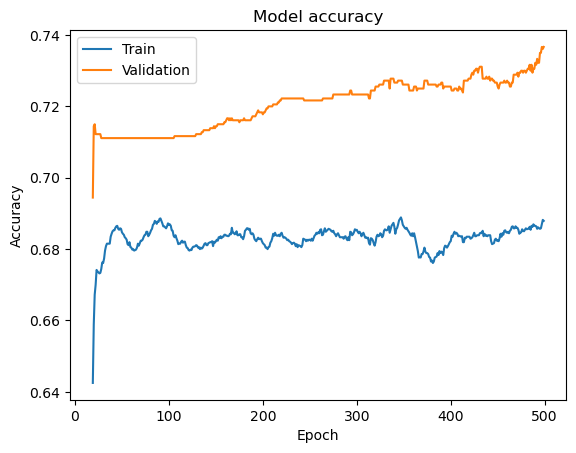

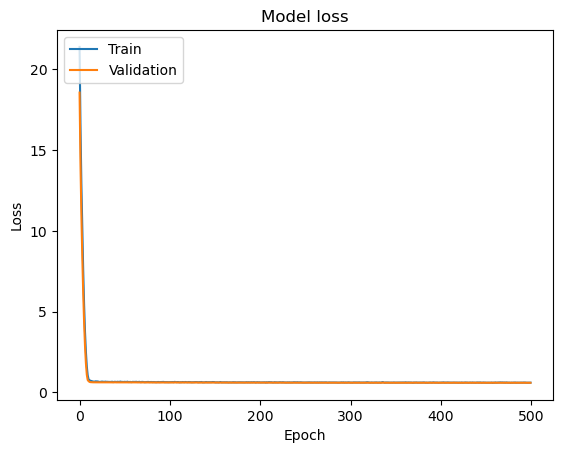

In [10]:
import matplotlib.pyplot as plt

import pandas as pd

# convert the accuracy data to a Pandas Series
train_acc = pd.Series(history.history["accuracy"])
val_acc = pd.Series(history.history["val_accuracy"])

# compute a rolling average with a window size of 10
window_size = 20
train_acc_smooth = train_acc.rolling(window_size).mean()
val_acc_smooth = val_acc.rolling(window_size).mean()

# plot the smoothed data
plt.plot(train_acc_smooth)
plt.plot(val_acc_smooth)
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()


# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)


2023-04-29 20:11:28.553621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-29 20:11:28.612340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training confusion matrix:
[[226  12]
 [102  20]]
Test confusion matrix:
[[62  0]
 [24  4]]


Training confusion matrix:
[[226  12]
 [102  20]]


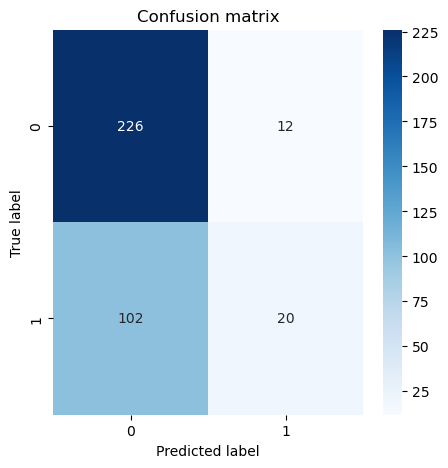

Test confusion matrix:
[[62  0]
 [24  4]]


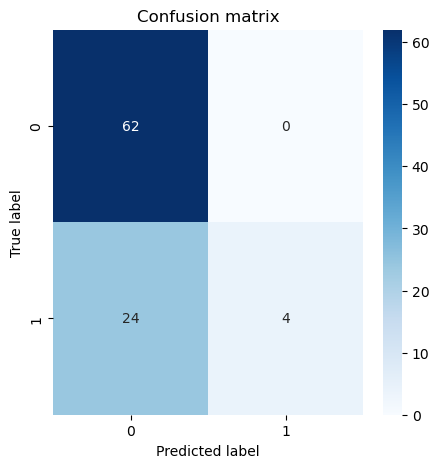

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to create and style confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Plot styled confusion matrix for training set
plot_confusion_matrix(train_cm)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)

# Plot styled confusion matrix for test set
plot_confusion_matrix(test_cm)
